# Experiment: Gradient Boosting Regression

Task: **regression**

Target: `Anomaly Scores`

Shared split: `split_time_70_15_15.csv` (time-aware, timestamp-grouped)

In [1]:
from __future__ import annotations

import json
import sys
from pathlib import Path

import numpy as np
import pandas as pd

from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler

SEED = 42
np.random.seed(SEED)

# Resolve repo root robustly so this works from notebooks/ or notebooks/anomaly_scores/.
cwd = Path.cwd().resolve()
candidates = [cwd] + list(cwd.parents)
REPO_ROOT = next((p for p in candidates if (p / 'src').exists() and (p / 'data').exists()), None)
if REPO_ROOT is None:
    raise FileNotFoundError('Could not locate repo root (expected src/ and data/).')
sys.path.insert(0, str(REPO_ROOT))

PREPROCESSED_ROOT = REPO_ROOT / 'data' / '02-preprocessed'
BASELINE_CONFIG_JSON = REPO_ROOT / 'config' / 'baseline_feature_config.json'
VIZ_CONFIG_JSON = REPO_ROOT / 'config' / 'visualization.json'

prepared_dirs = sorted([p for p in PREPROCESSED_ROOT.iterdir() if p.is_dir()], key=lambda p: p.name)
if not prepared_dirs:
    raise FileNotFoundError(f'No prepared datasets found under: {PREPROCESSED_ROOT}')
DATASET_DIR = prepared_dirs[-1]

cleaned_parquet = DATASET_DIR / 'cleaned.parquet'
cleaned_csv = DATASET_DIR / 'cleaned.csv'
split_time_csv = DATASET_DIR / 'split_time_70_15_15.csv'

print(f'Using prepared dataset: {DATASET_DIR}')
print(f'Using baseline config:  {BASELINE_CONFIG_JSON}')
print(f'Using time split:      {split_time_csv.name}')

if cleaned_parquet.exists():
    df = pd.read_parquet(cleaned_parquet)
elif cleaned_csv.exists():
    df = pd.read_csv(cleaned_csv)
else:
    raise FileNotFoundError('Expected cleaned.parquet or cleaned.csv')

if not split_time_csv.exists():
    raise FileNotFoundError(f'Missing time-aware split artifact: {split_time_csv}')
splits = pd.read_csv(split_time_csv)

from src.pipelines.features import (
    BaselineFeatureConfig,
    apply_baseline_feature_config,
    load_baseline_feature_config,
)

cfg0 = load_baseline_feature_config(BASELINE_CONFIG_JSON)
# Override the target to Anomaly Scores (regression) and drop Attack Type to reduce leakage.
cfg = BaselineFeatureConfig(
    target_col='Anomaly Scores',
    row_id_col=cfg0.row_id_col,
    drop_cols=sorted(set(cfg0.drop_cols + ['Attack Type'])),
    timestamp_cols=cfg0.timestamp_cols,
    port_cols=cfg0.port_cols,
)

required_cols = {cfg.row_id_col, cfg.target_col, 'Timestamp'}
missing_required = required_cols - set(df.columns)
if missing_required:
    raise KeyError(f'Missing required columns in cleaned data: {sorted(missing_required)}')

# Features and regression target
X_full = apply_baseline_feature_config(df, cfg)
y_full = pd.to_numeric(df[cfg.target_col], errors='coerce')

# Split join by row_id
df_split = df[[cfg.row_id_col]].merge(splits[[cfg.row_id_col, 'split']], on=cfg.row_id_col, how='left')
if df_split['split'].isna().any():
    raise ValueError('Some rows are missing split assignments (time split join failed)')

mask_train = df_split['split'].eq('train')
mask_val = df_split['split'].eq('val')
mask_test = df_split['split'].eq('test')

X_train, y_train = X_full.loc[mask_train].reset_index(drop=True), y_full.loc[mask_train].reset_index(drop=True)
X_val, y_val = X_full.loc[mask_val].reset_index(drop=True), y_full.loc[mask_val].reset_index(drop=True)
X_test, y_test = X_full.loc[mask_test].reset_index(drop=True), y_full.loc[mask_test].reset_index(drop=True)

# Keep timestamps for test rows for time-based charts
ts_full = pd.to_datetime(df['Timestamp'], errors='coerce', utc=True)
ts_test = ts_full.loc[mask_test].reset_index(drop=True)

print('Split sizes:', X_train.shape, X_val.shape, X_test.shape)
print('Target summary (train):', y_train.describe())


Using prepared dataset: C:\repos\ml-cybersecurity_attacks\data\02-preprocessed\cybersecurity_attacks_v1_2025-12-29
Using baseline config:  C:\repos\ml-cybersecurity_attacks\config\baseline_feature_config.json
Using time split:      split_time_70_15_15.csv
Split sizes: (28000, 24) (6000, 24) (6000, 24)
Target summary (train): count    28000.000000
mean        50.075863
std         28.826157
min          0.000000
25%         25.200000
50%         50.400000
75%         74.972500
max         99.990000
Name: Anomaly Scores, dtype: float64


In [2]:
# Build preprocessing: impute + one-hot for categoricals; impute (+ optional scale) for numeric

cat_cols = [c for c in X_train.columns if X_train[c].dtype == 'object' or str(X_train[c].dtype).startswith('string')]
num_cols = [c for c in X_train.columns if c not in cat_cols]

cat_pipe = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False)),
])

num_steps = [
    ('imputer', SimpleImputer(strategy='median')),
    # ('scaler', StandardScaler()),
]
num_steps = [s for s in num_steps if not (isinstance(s, str) or s[0].startswith('#'))]
num_pipe = Pipeline(steps=num_steps)

preprocess = ColumnTransformer(
    transformers=[('cat', cat_pipe, cat_cols), ('num', num_pipe, num_cols)],
    remainder='drop',
)

print(f'Categorical cols: {len(cat_cols)}')
print(f'Numeric cols:     {len(num_cols)}')


Categorical cols: 11
Numeric cols:     13


In [3]:
# Model definition + training

from sklearn.ensemble import GradientBoostingRegressor

model = GradientBoostingRegressor(random_state=SEED)

reg = Pipeline(steps=[('preprocess', preprocess), ('model', model)])
reg.fit(X_train, y_train)


,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('preprocess', ...), ('model', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('cat', ...), ('num', ...)]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'drop'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of the different transformers cont

In [5]:
from __future__ import annotations

import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def eval_split(name: str, y_true, y_pred) -> dict[str, float]:
    mae = mean_absolute_error(y_true, y_pred)
    rmse = float(np.sqrt(mean_squared_error(y_true, y_pred)))
    r2 = r2_score(y_true, y_pred)
    print(f'\n== {name} ==')
    print(f'MAE:  {mae:.4f}')
    print(f'RMSE: {rmse:.4f}')
    print(f'R2:   {r2:.4f}')
    return {'mae': float(mae), 'rmse': rmse, 'r2': float(r2)}

val_pred = reg.predict(X_val)
test_pred = reg.predict(X_test)

val_metrics = eval_split('val', y_val, val_pred)
test_metrics = eval_split('test', y_test, test_pred)



== val ==
MAE:  25.0487
RMSE: 28.9652
R2:   -0.0026

== test ==
MAE:  25.0418
RMSE: 28.9154
R2:   -0.0006


Loaded COLOR_PALLETE (9 colors) from visualization.json


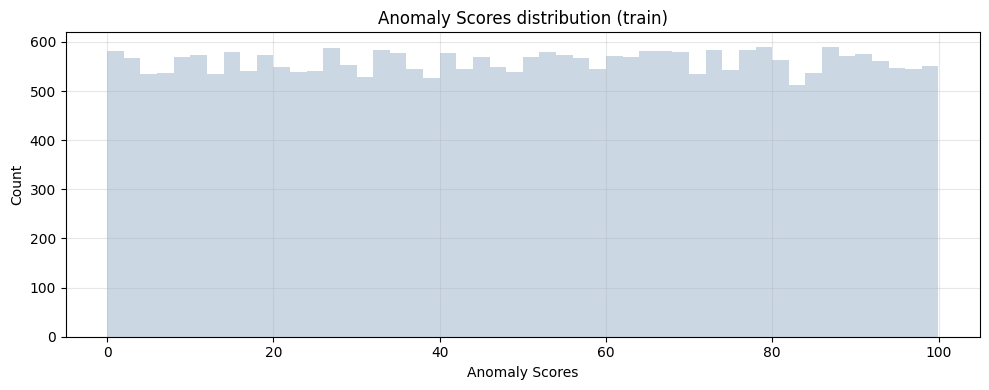

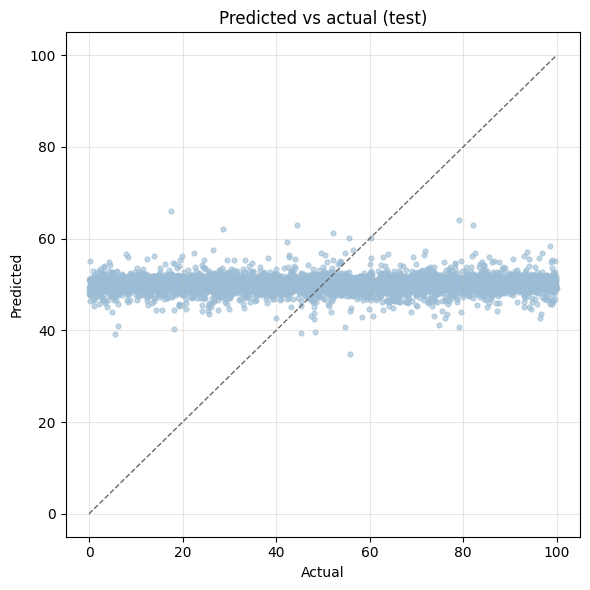

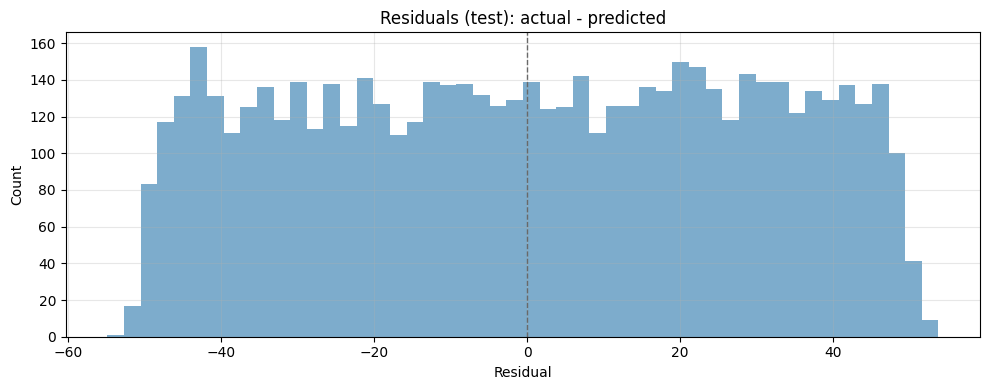

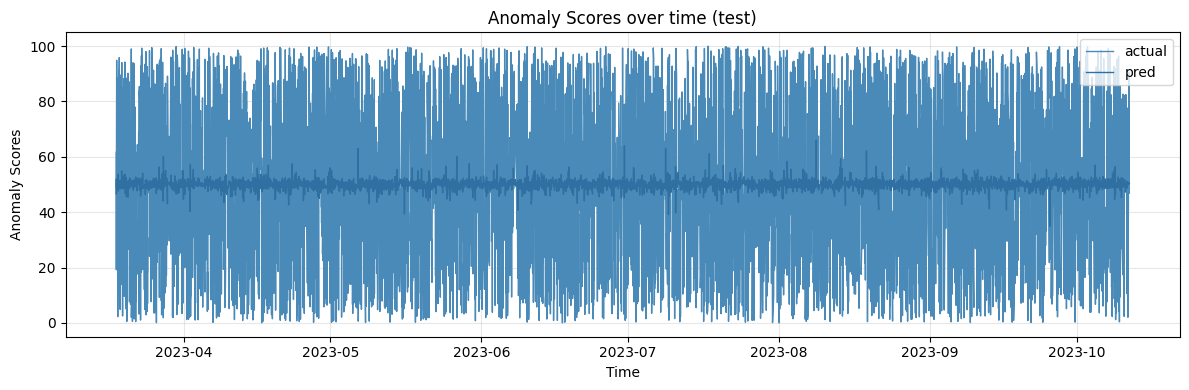

In [6]:
# Charts (uses config/visualization.json color_palette via COLOR_PALLETE)

import json
from matplotlib import pyplot as plt
from cycler import cycler

def load_color_palette(path: Path) -> list[str]:
    with open(path, 'r', encoding='utf-8') as f:
        payload = json.load(f)
    palette = payload.get('visualization', {}).get('color_palette', [])
    if not isinstance(palette, list) or not palette:
        raise ValueError(f"Missing/invalid visualization.color_palette in {path}")
    return [str(c) for c in palette]

COLOR_PALLETE = load_color_palette(VIZ_CONFIG_JSON)
plt.rcParams['axes.prop_cycle'] = cycler(color=COLOR_PALLETE)
print(f'Loaded COLOR_PALLETE ({len(COLOR_PALLETE)} colors) from {VIZ_CONFIG_JSON.name}')

# 1) Target distribution (train)
fig, ax = plt.subplots(figsize=(10, 4))
ax.hist(y_train, bins=50, color=COLOR_PALLETE[0], alpha=0.9)
ax.set_title('Anomaly Scores distribution (train)')
ax.set_xlabel('Anomaly Scores')
ax.set_ylabel('Count')
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# 2) Predicted vs actual (test)
fig, ax = plt.subplots(figsize=(6, 6))
ax.scatter(y_test, test_pred, s=12, alpha=0.6, color=COLOR_PALLETE[1])
mn = float(min(y_test.min(), test_pred.min()))
mx = float(max(y_test.max(), test_pred.max()))
ax.plot([mn, mx], [mn, mx], linestyle='--', color=COLOR_PALLETE[-1], linewidth=1)
ax.set_title('Predicted vs actual (test)')
ax.set_xlabel('Actual')
ax.set_ylabel('Predicted')
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# 3) Residual histogram (test)
residuals = (y_test - test_pred)
fig, ax = plt.subplots(figsize=(10, 4))
ax.hist(residuals, bins=50, color=COLOR_PALLETE[2], alpha=0.9)
ax.axvline(0.0, color=COLOR_PALLETE[-1], linestyle='--', linewidth=1)
ax.set_title('Residuals (test): actual - predicted')
ax.set_xlabel('Residual')
ax.set_ylabel('Count')
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# 4) Actual vs predicted over time (test; chronological)
df_time = pd.DataFrame({'Timestamp': ts_test, 'actual': y_test, 'pred': test_pred}).dropna()
df_time = df_time.sort_values('Timestamp').reset_index(drop=True)
fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(df_time['Timestamp'], df_time['actual'], color=COLOR_PALLETE[3], linewidth=1, label='actual')
ax.plot(df_time['Timestamp'], df_time['pred'], color=COLOR_PALLETE[4], linewidth=1, label='pred')
ax.set_title('Anomaly Scores over time (test)')
ax.set_xlabel('Time')
ax.set_ylabel('Anomaly Scores')
ax.legend()
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()
